# Ψεύτικα Πρόσωπα

**Φοιτήτρια:** Ειρήνη Χρυσικοπούλου  
**Τμήμα:** ΔΠΜΣ ΑΛΜΑ  
**Α.Μ.:** 7115142300020

To πρόβλημα είναι βασισμένο στο θέμα του ΠΔΤΝ: https://pdtn.gr/contests/pdtn25a/tasks/deepfakes

Θα δείτε ανάμεικτες εικόνες που δημιουργήθηκαν από τεχνητή νοημοσύνη (AI) και αληθινές φωτογραφίες. Ο στόχος σας είναι να εντοπίσετε τις ψεύτικες με ένα μοντέλο ΤΝ.

Δοκιμάστε να εκπαιδεύσετε ένα νευρωνικό (ShuffleNet v2) για να κάνετε το διαχωρισμό. Δίνονται πολλές εικόνες εκπαίδευσης τις οποίες μπορείτε να τις χρησιμοποιήσετε χωρίζοντάς τες σε train και test για να αποφύγετε το overfitting. Για να βελτιωθεί το μοντέλο σας μπορείτε να δοκιμάσετε διάφορες τεχνικές όπως augmentations στις φωτογραφίες, ξεκινώντας από ένα pretrained μοντέλο σε αντίστοιχου τύπου δεδομένα, θέτοντας κατάλληλες τιμές στο dropout κτλ. Στο site του ΠΔΤΝ υπάρχει ένα extra public dataset όπου μπορείτε να αξιολογήσετε το μοντέλο σας καθώς και ένα private στο οποίο θα γίνει η τελική αξιολόγηση.

In [7]:
import os
import numpy as np
import torch
from torchvision import transforms, datasets, models
from gdown import download
from zipfile import ZipFile
from PIL import Image
import torch.nn as nn

# 1. Κατεβάζουμε όλες τις εικόνες

In [8]:
def download_and_extract(id, filename, extracted_folder):
    # Κατεβάστε το αρχείο zip εάν δεν υπάρχει ήδη
    if not os.path.exists(filename):
        print("Γίνεται φόρτωση του αρχείου",filename)
        download(id=id, output=filename, quiet=False)

    # Εξαγωγή του αρχείου zip εάν ο φάκελος δεν υπάρχει ήδη
    if not os.path.exists(extracted_folder):
        print("Γίνεται αποσυμπίεση των αρχείων...")
        with ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
main_folder = "deepfakes"
download_and_extract('16vuZcaQbd6Mmr4QZgKHJ_Y9UolOef12z', "deepfakes.zip", main_folder)

# 2. Δημιουργούμε τα Datasets

Ορίζουμε τα train και validation Dataset και τους αντίστοιχους DataLoader

In [9]:
train_folder = os.path.join(main_folder, "train")
validation_folder = os.path.join(main_folder, "validation")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Train dataset size: 40000
Validation dataset size: 2000


# 3. Ορίζουμε το μοντέλο προς εκπαίδευση

**ΣΗΜΑΝΤΙΚΟ!!**

Για την άσκηση πρέπει να χρησιμοποιήσετε υποχρεωτικά το μοντέλο `shufflenet_v2_x1_0` από τα μοντέλα της `torchvision`

In [10]:
model = models.shufflenet_v2_x1_0(num_classes = 2)

if True:
    # Προαιρετικά: το αρχικοποιούμε προ-εκπαιδευμένο με βάση το ImageNet
    model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
    # Καθώς το imagenet έχει 1000 κατηγορίες τις αλλάζουμε σε 2
    model.fc = torch.nn.Linear(model.fc.in_features, 2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()
model.to(device);

# 4. Εκπαιδεύστε το μοντέλο

Για μεγαλύτερη ταχύτητα επιλέξτε στο Colab τη χρήση GPU π.χ. T4

- Το μοντέλο εκπαιδεύεται χρησιμοποιώντας τον Adam optimizer με learning rate 0.001 και CrossEntropyLoss για binary classification.
-Εφαρμόζουμε early stopping με patience 3 epochs, που σημαίνει ότι η εκπαίδευση διακόπτεται αυτόματα αν δεν υπάρξει βελτίωση του validation accuracy για 3 συνεχόμενα epochs.
- Παράλληλα αποθηκεύουμε και στο τέλος φορτώνουμε τα βάρη του καλύτερου μοντέλου

In [11]:
def train(model, train_loader, test_loader, optimizer, scheduler, device, epochs=10, early_stopping=True, patience=3):

    min_improvement = 0.003
    criterion = torch.nn.CrossEntropyLoss()

    best_accuracy = 0.0
    best_model_weights = None
    epochs_without_improvement = 0

    print("Starting training:\n")
    print(f" Epochs: {epochs}\n")
    if early_stopping:
        print(f"Early Stopping: ON (patience={patience})\n")
    else:
        print("Early Stopping: OFF\n")
    print("-" * 60)

    for epoch in range(epochs):

        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # VALIDATION
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss = total_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        test_accuracy = test_correct / test_total

        # FIX: ReduceLROnPlateau needs test_accuracy as argument
        scheduler.step(test_accuracy)

        improvement = test_accuracy - best_accuracy

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, Test Acc={test_accuracy:.4f}")

        if improvement > min_improvement:
            best_accuracy = test_accuracy
            best_model_weights = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if early_stopping and epochs_without_improvement >= patience:
                print(f"\n Early stopping due to no improvement for {patience} epochs.")
                break

    # Load best weights to model
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    print("Training completed")
    return None

Επειδή έχουμε χρησιμοποιήσει ένα προεκπαιδευμένο μοντέλο, μπορούμε να εκπαιδεύσουμε μόνο το τελευταίο επίπεδο του νευρωνικού. Αυτό μας δίνει accuracy κοντά στο 80%.

Για να πάρουμε καλύτερο accuracy θα εκπαιδεύσουμε και το προτελευταίο.Για να αποφύγουμε όσο το δυνατόν overfitting εχουμε ορίσει:


1. Weight decay (1e-4) στον optimizer  
2. Early stopping με patience=3
3. Χαμηλό learning rate-ειδικά στο προτελευταίο layer



In [12]:
for param in model.parameters():
    param.requires_grad = False #  Παγώνουμε όλες τις παραμέτρους του προεκπαιδευμένου μοντέλου

for param in model.stage4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training classifier only with {trainable_params} trainable parameters")

optimizer = torch.optim.Adam([
    {'params': model.stage4.parameters(), 'lr': 3e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4}
], weight_decay=2e-4)  #  Προσθέτει penalty term στο loss

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.7, patience=3, min_lr=1e-6,
)

# Train με τα augmented data
train(model, train_loader, validation_loader, optimizer, scheduler, device,
      epochs=15, early_stopping=True, patience=3)

Training classifier only with 503402 trainable parameters
Starting training:

 Epochs: 15

Early Stopping: ON (patience=3)

------------------------------------------------------------
Epoch 1/15: Train Loss=0.4869, Train Acc=0.8102, Test Acc=0.8780
Epoch 2/15: Train Loss=0.2963, Train Acc=0.8821, Test Acc=0.8995
Epoch 3/15: Train Loss=0.2483, Train Acc=0.8992, Test Acc=0.9070
Epoch 4/15: Train Loss=0.2219, Train Acc=0.9116, Test Acc=0.9080
Epoch 5/15: Train Loss=0.2000, Train Acc=0.9207, Test Acc=0.9115
Epoch 6/15: Train Loss=0.1821, Train Acc=0.9288, Test Acc=0.9125
Epoch 7/15: Train Loss=0.1685, Train Acc=0.9341, Test Acc=0.9200
Epoch 8/15: Train Loss=0.1559, Train Acc=0.9392, Test Acc=0.9215
Epoch 9/15: Train Loss=0.1402, Train Acc=0.9460, Test Acc=0.9160
Epoch 10/15: Train Loss=0.1298, Train Acc=0.9505, Test Acc=0.9220

 Early stopping due to no improvement for 3 epochs.
Training completed


# 5. Εξαγωγή των βαρών

Σώστε τα βάρη του νευρωνικού ως `.png` εικόνα και ανεβάστε την εικόνα στο site για υποβολή.

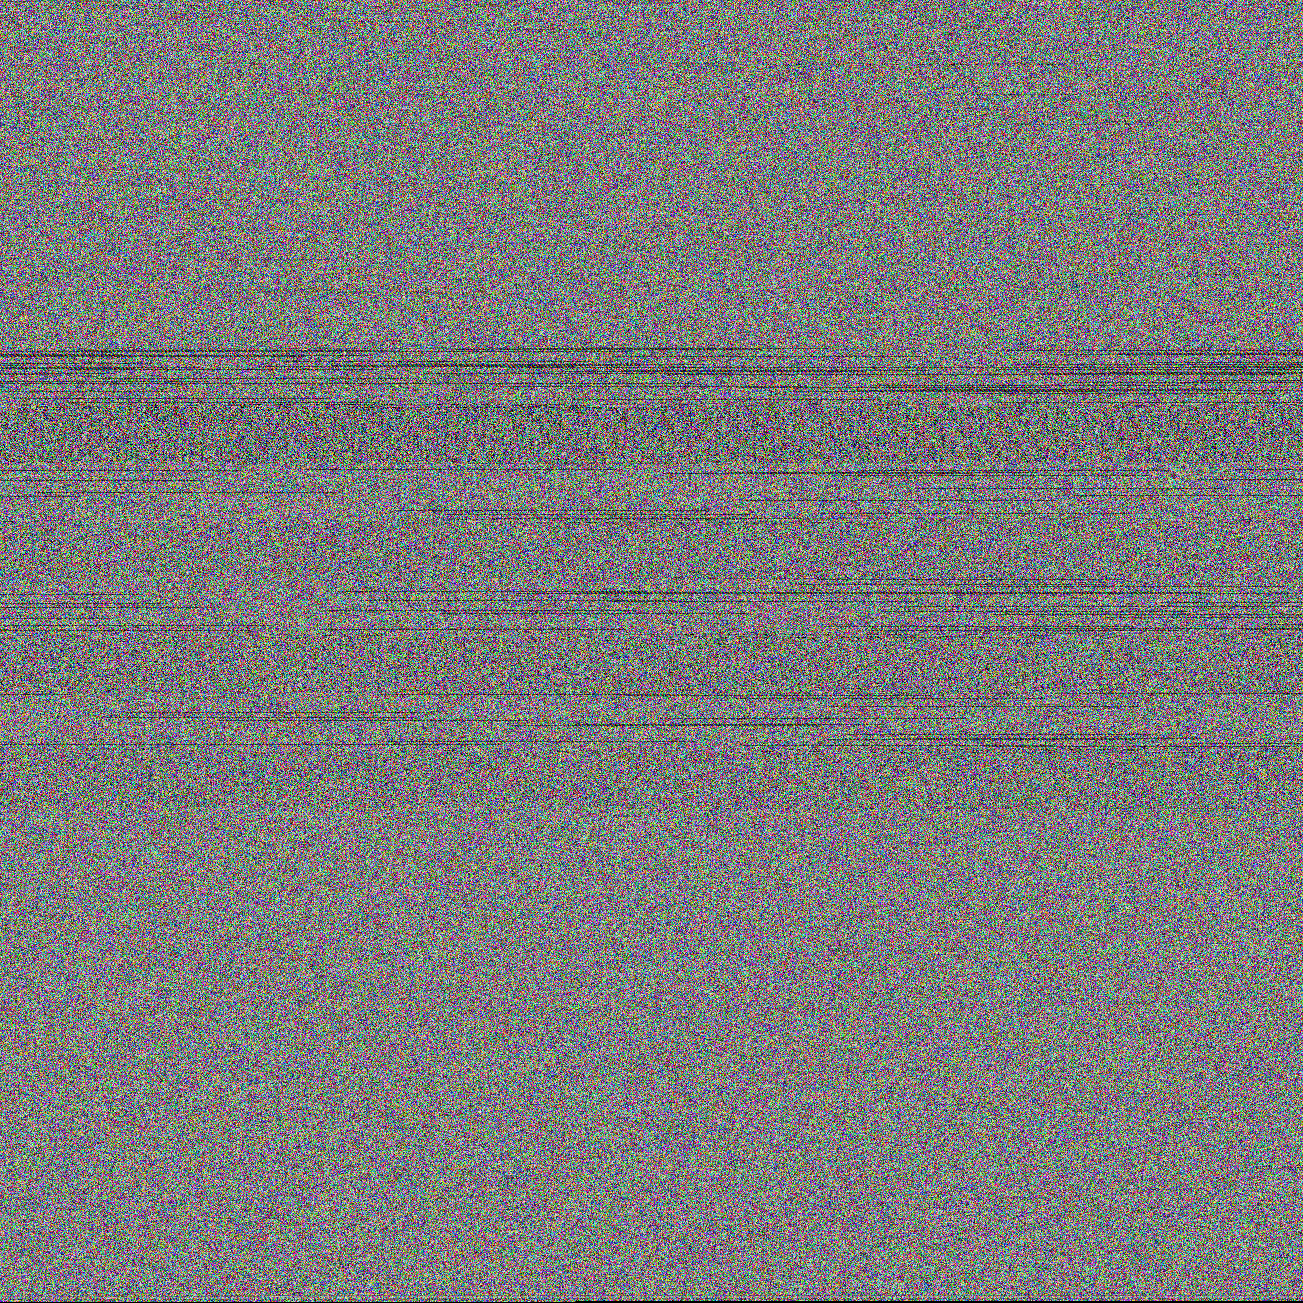

In [14]:
def modelToImage(model):
    model.eval()
    state_dict = model.state_dict()
    weights = []
    for key, tensor in state_dict.items():
        if 'num_batches_tracked' in key: continue
        w = tensor.flatten().cpu().numpy()
        weights.append(w)
    weights = np.concatenate(weights).astype(np.float32)
    byte_array = weights.view(np.uint8)
    L = len(byte_array) / 3
    N = int( np.ceil( np.sqrt(L) ) )
    padding = 3*N*N - len(byte_array)
    byte_array = np.pad(byte_array, (0, padding), mode='constant')
    img = Image.fromarray(byte_array.reshape(N,N,3).astype(np.uint8), mode='RGB')
    img.save("weights.png")
    return img

modelToImage(model)